In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [2]:
# 读取数据
data_path = "./data/df_long_clean.pkl"
df = pd.read_pickle(data_path)

In [3]:
df.head()

,id,sex,age,ecg,ppg,hbp,lbp
0,20250521001,2,26.0,"[-517.0, -523.0, -529.0, -535.0, -538.0, -538....","[342619.0, 342553.0, 342553.0, 342553.0, 34255...",112.0,72.0
1,20250521001,2,26.0,"[-611.0, -608.0, -605.0, -608.0, -604.0, -600....","[335155.0, 335155.0, 335155.0, 335155.0, 33515...",103.0,72.0
2,20250521001,2,26.0,"[-7355.0, -7362.0, -7360.0, -7368.0, -7371.0, ...","[106897.0, 106897.0, 106897.0, 106897.0, 10668...",102.0,68.0
3,20250521001,2,26.0,"[-6323.0, -6327.0, -6326.0, -6322.0, -6320.0, ...","[125504.0, 125504.0, 125504.0, 125504.0, 12550...",91.0,59.0
4,20250521003,2,27.0,"[-53.0, -44.0, -58.0, -74.0, -53.0, -56.0, -46...","[170290.0, 170290.0, 170328.0, 170328.0, 17032...",106.0,72.0


In [4]:
# 采样频率500HZ
freq = 500

In [5]:
from scipy.signal import butter, filtfilt


def normalize_signal(sig: np.ndarray) -> np.ndarray:
    """
    标准化信号，使其均值为0，标准差为1。

    Args:
        sig (np.ndarray): 输入信号

    Returns:
        np.ndarray: 标准化后的信号
    """
    return (sig - np.mean(sig)) / (np.std(sig) + 1e-8)


def bandpass_filter(
    sig: np.ndarray, fs: int, lowcut: float, highcut: float, order: int = 2
):
    """
    Apply a bandpass filter to the input signal.

    Args:
        sig (np.ndarray): The input signal.
        fs (int): The sampling frequency of the input signal.
        lowcut (float): The low cutoff frequency of the bandpass filter.
        highcut (float): The high cutoff frequency of the bandpass filter.

    Return:
        sig_filtered (np.ndarray): The filtered signal using a Butterworth bandpass filter.
    """
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype="band")
    sig_filtered = filtfilt(b, a, sig)
    return sig_filtered

df['normalized_ppg'] = df["ppg"].apply(lambda x: normalize_signal(x))
df["denoised_ppg"] = df["normalized_ppg"].apply(
    lambda x: bandpass_filter(x, fs=freq, lowcut=0.5, highcut=4)
)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


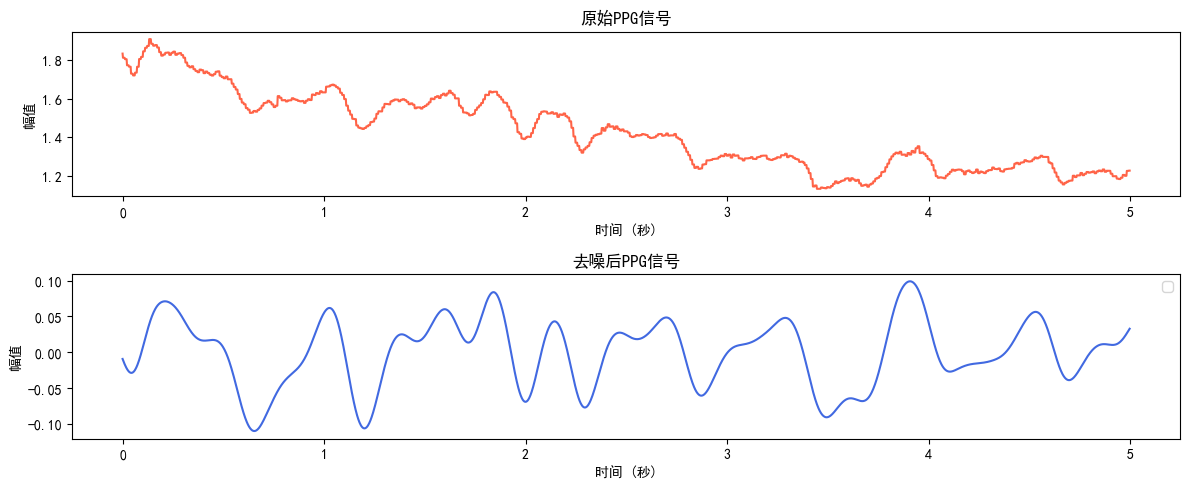

In [6]:
raw_ppg = df.iloc[0]["normalized_ppg"]
denoised_ppg = df.iloc[0]["denoised_ppg"]

fs = freq  # 采样频率
n = int(5 * fs)

t = np.arange(n) / fs

plt.figure(figsize=(12, 5))
plt.subplot(2, 1, 1)
plt.plot(t, raw_ppg[:n], color="tomato")
plt.title("原始PPG信号")
plt.xlabel("时间 (秒)")
plt.ylabel("幅值")

plt.subplot(2, 1, 2)
plt.plot(t, denoised_ppg[:n], color="royalblue")
plt.title("去噪后PPG信号")
plt.xlabel("时间 (秒)")
plt.ylabel("幅值")
plt.legend()

plt.tight_layout()
plt.show()

In [7]:
import pywt
from scipy.signal import butter, filtfilt


def adb_2_ecg(adb):
    """将adb信号转换为ECG信号。

    Args:
        adb (np.ndarray): 原始adb信号

    Returns:
        np.ndarray: 转换后的ECG信号
    """
    VREF = 2.42
    G = 6
    ecg = adb * 1000 * VREF / (32767 * G)
    return ecg


def highpass_filter(sig, fs=500, cutoff=5, order=4):
    """高通滤波器，去除低频干扰。

    Args:
        sig (np.ndarray): 输入信号
        fs (int): 采样率，默认500Hz
        cutoff (float): 截止频率，默认5Hz
        order (int): 滤波器阶数，默认4

    Returns:
        np.ndarray: 滤波后的信号
    """
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype="high")
    filtered_sig = filtfilt(b, a, sig)
    return filtered_sig


def wt_filter(sig, wavelet="db4", threshold=0.1):
    """小波去噪

    Args:
        sig (np.ndarray): 输入信号
        wavelet (str, optional): 小波基，默认"db4"
        threshold (float, optional): 阈值，默认0.1

    Returns:
        np.ndarray: 去噪后的信号
    """
    coeffs = pywt.wavedec(sig, wavelet)
    coeffs_thresholded = [pywt.threshold(c, threshold, mode="soft") for c in coeffs]
    return pywt.waverec(coeffs_thresholded, wavelet)

In [8]:
df['normalized_ecg'] = df["ecg"].apply(lambda x: adb_2_ecg(x))
df["denoised_ecg"] = df["normalized_ecg"].apply(
    lambda x: wt_filter(highpass_filter(x)))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


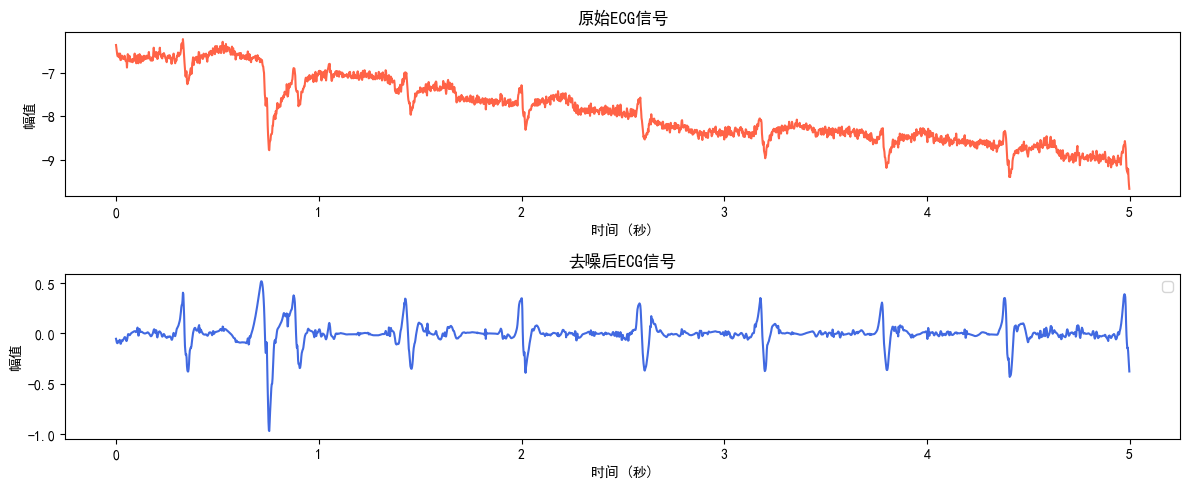

In [9]:
raw_ecg = df.iloc[0]["normalized_ecg"]
denoised_ecg = df.iloc[0]["denoised_ecg"]

fs = freq  # 采样频率
n = int(5 * fs)

t = np.arange(n) / fs

plt.figure(figsize=(12, 5))
plt.subplot(2, 1, 1)
plt.plot(t, raw_ecg[:n], color="tomato")
plt.title("原始ECG信号")
plt.xlabel("时间 (秒)")
plt.ylabel("幅值")

plt.subplot(2, 1, 2)
plt.plot(t, denoised_ecg[:n], color="royalblue")
plt.title("去噪后ECG信号")
plt.xlabel("时间 (秒)")
plt.ylabel("幅值")
plt.legend()

plt.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


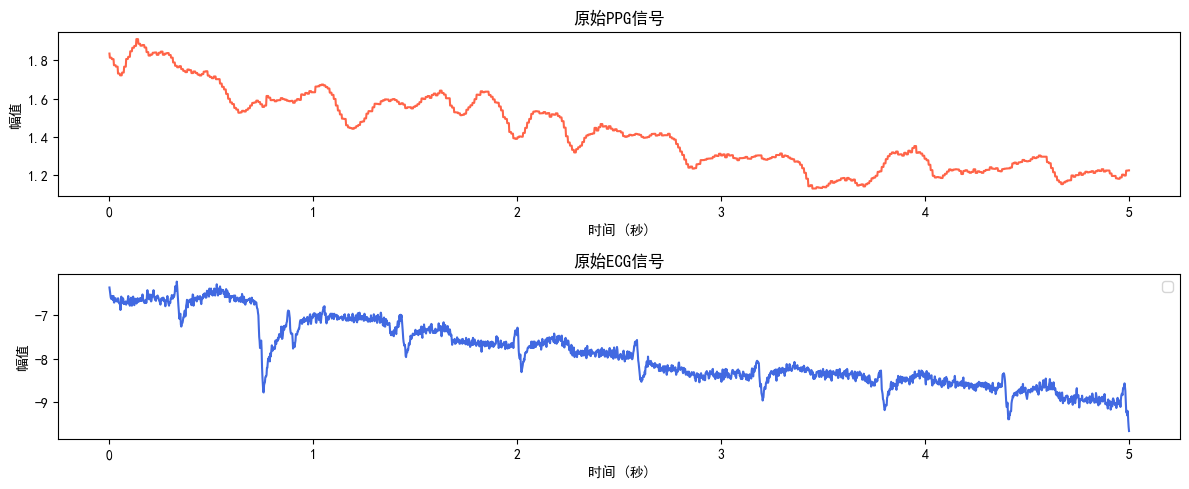

In [13]:
# ppg，ecg信号对比

raw_ppg = df.iloc[0]["normalized_ppg"]
raw_ecg = df.iloc[0]["normalized_ecg"]

fs = freq  # 采样频率
n = int(5 * fs)

t = np.arange(n) / fs

plt.figure(figsize=(12, 5))
plt.subplot(2, 1, 1)
plt.plot(t, raw_ppg[:n], color="tomato")
plt.title("原始PPG信号")
plt.xlabel("时间 (秒)")
plt.ylabel("幅值")

plt.subplot(2, 1, 2)
plt.plot(t, raw_ecg[:n], color="royalblue")
plt.title("原始ECG信号")
plt.xlabel("时间 (秒)")
plt.ylabel("幅值")
plt.legend()

plt.tight_layout()
plt.show()